# NER task

## Data annotation

### IOB 
- I means "inside entity"
- B means "begin of entity"
- O means "not a entity"

Given some examples:\
I-Person\
B-Person\
B-Organization\
I-Organization\
O

### IOBES
- I/M means "inside entity"
- B means "begin of entity"
- O means "not a entity"
- E means "end of entity"
- S means "a single word entity"

Given a sample:\
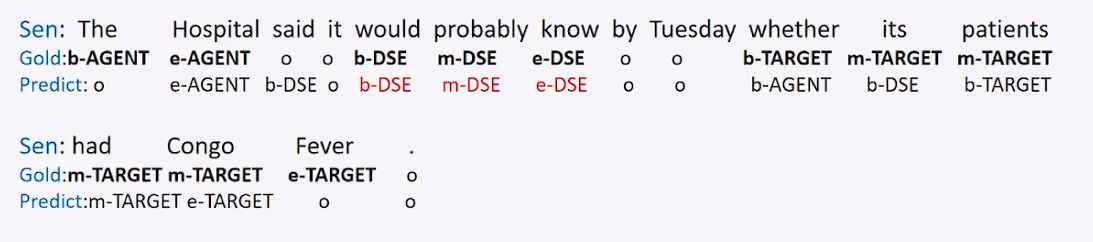

There are 3 entities in total sentence, thr "GOLD" is the label of entity, and the "Predict" is prediction.

predict_num = 2\
Gold_num = 3\
correct_num = 1\
\
then the f1 score and the Precision(P), Recall(R):\
\
$P= \frac{1}{2}, R = \frac{1}{3}, f1 = \frac{2*P*R}{P+R}$

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, Pipeline
from datasets import *
import evaluate
import numpy as np

In [2]:
data = DatasetDict.load_from_disk("ner_data")
print(data)
print(data["train"][0])
print(data["train"].features) # check features' property

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4637
    })
})
{'id': '0', 'tokens': ['海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间', '的', '海', '域', '。'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0]}
{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)}


In [3]:
tokenizer = AutoTokenizer.from_pretrained("./macbert-base-chinese/")

res = tokenizer(data['train'][0]['tokens'], is_split_into_words=True).word_ids()
tokenized_sample = tokenizer(data['train']['tokens'][0], is_split_into_words=True)

label_list = data["train"].features['ner_tags'].feature.names # extract labels

print(res)
print(tokenized_sample)
print(label_list)

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, None]
{'input_ids': [101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305, 680, 7032, 7305, 722, 7313, 4638, 3862, 1818, 511, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']


## Main preprocess content: map the label !!!

In [4]:
def preprocess_func(example, tokenizer=tokenizer):
    tokenized_example = tokenizer(example["tokens"], max_length=128, truncation=True, padding=True, return_tensors='pt', is_split_into_words=True)
    labels = []
    for ids, label in enumerate(example['ner_tags']): # iterate ner_tags
        word_ids = tokenized_example.word_ids(batch_index=ids) # get every ner_tags' word_ids
        label_temp = []
        for word_id in word_ids:
            if word_id == None:
                label_temp.append(-100) # 'None' means [CLS] or [SEP] 
            else:
                label_temp.append(label[word_id]) # add label through word_ids(ner_tags[word_ids])
        labels.append(label_temp)
    tokenized_example['labels'] = labels

    return tokenized_example

data = data.map(preprocess_func, batched=True, remove_columns=data['train'].column_names)
print(data)
print(data['train'][0])

Map:   0%|          | 0/20865 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4637
    })
})
{'input_ids': [101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305, 680, 7032, 7305, 722, 7313, 4638, 3862, 1818, 511, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [5]:
ner_model = AutoModelForTokenClassification.from_pretrained("./macbert-base-chinese/", num_labels=len(label_list))
ner_model.config.num_labels

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ./macbert-base-chinese/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


7

In [6]:
seqeval = evaluate.load('seqeval')
seqeval

EvaluationModule(name: "seqeval", module_type: "metric", features: {'predictions': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence')}, usage: """
Produces labelling scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: List of List of predicted labels (Estimated targets as returned by a tagger)
    references: List of List of reference labels (Ground truth (correct) target values)
    suffix: True if the IOB prefix is after type, False otherwise. default: False
    scheme: Specify target tagging scheme. Should be one of ["IOB1", "IOB2", "IOE1", "IOE2", "IOBES", "BILOU"].
        default: None
    mode: Whether to count correct entity labels with incorrect I/B tags as true positives or not.
        If you want to only count exact matches, pass mode="strict". default: None.
    sample_weight: Array-like of sha

In [7]:
label_sam = data['train']['labels'][:2]
print(label_sam)

[[-100, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [8]:
true_sam = [[label_list[p] for p in pred if p != -100] for pred in label_sam]
print(true_sam)

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


In [9]:
def eval_func(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    predictions = [[label_list[pred] for pred in batch if pred != -100]
                for batch in predictions] # eval batches
    labels = [[label_list[label] for label in batch if label != -100] 
                for batch in labels]

    result = seqeval.compute(predictions=predictions, references=labels)

    return {
        "f1": result['overall_f1'],
        "precision": result['overall_precision'],
        "recall": result['overall_recall']
    }

In [10]:
train_arg = TrainingArguments(
            output_dir="./ner_checkpoints",
            save_strategy="epoch",
            save_total_limit=3,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            logging_steps=100,
)
train_arg

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_always_push=False,
hub_mod

In [12]:
trainer = Trainer(
        model = ner_model,
        args=train_arg,
        train_dataset=data['train'],
        eval_dataset=data['test'],
        data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer),
        compute_metrics=eval_func,
)
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss



KeyboardInterrupt



In [ ]:
ner_model.config.id2label = {ids: label for ids, label in enumerate(label_list)}

sentence = "陈先生在江南钓鱼"
pipe = Pipeline("token-classification", tokenizer=tokenier, device=0, aggragation='simple')
ner_result = pipe(sentence)

result = {}
for ner in ner_result:
    result[ner_result['entity_group']] = []
for ner in ner_result:
    result[ner['entity_group']].append(sentence[ner['start']: ner['end']])

print(result)